# Loading the data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [2]:
fn_src = 'https://www.dropbox.com/sh/n4924ipcfjqc0t6/AADOv9JYMUBK1tlg9P71gSSra/example_data_s1.pickle?dl=1'
fn_dst = 'example_data_s1.pickle'

import os
from six.moves import urllib

if os.path.isfile(fn_dst):
    print('File %s is already downloaded' % fn_dst)
else:        
    urllib.request.urlretrieve(fn_src, fn_dst)

File example_data_s1.pickle is already downloaded


In [3]:
with open('example_data_s1.pickle', 'rb') as fp:
    X,y = pickle.load(fp)

In [4]:
tsamp = 0.05  # sampling time in seconds

print(X)
nt = print('nt=',X.shape[0])
nneuron = print('nneuron=',X.shape[1])
nout = print('nout=',y.shape[1])
ttotal = print('ttotal=',X.shape[0]*tsamp)

[[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 1. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
nt= 61339
nneuron= 52
nout= 2
ttotal= 3066.9500000000003


# Fitting a Memoryless Linear Model

In [5]:
from sklearn.model_selection import train_test_split

Xtr, Xts, ytr, yts= train_test_split(X, y, test_size=0.33)

In [6]:
regr = LinearRegression()
regr.fit(Xtr,ytr)
regr.coef_

yhat = regr.predict(Xts)
rsq= r2_score(yts, yhat)
print(rsq)

0.4617440295410513


Text(0, 0.5, 'Predicted v in y')

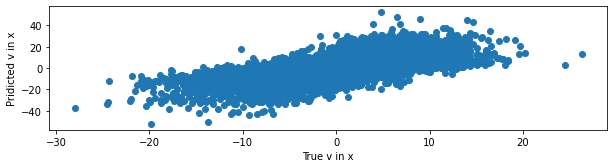

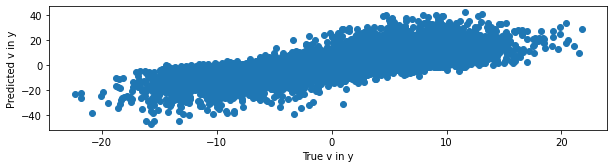

In [7]:
plt.figure(figsize=(10,5))
plt.subplot(211)
plt.scatter(yhat[:,0],yts[:,0])
plt.xlabel('True v in x')
plt.ylabel('Pridicted v in x')

plt.figure(figsize=(10,5))
plt.subplot(212)
plt.scatter(yhat[:,1],yts[:,1])
plt.xlabel('True v in y')
plt.ylabel('Predicted v in y')


# Fitting Models with Delay

In [8]:
def create_dly_data(X,y,dly):
    n, p = X.shape
    Xdly = np.zeros((n-dly, (dly+1)*p))
    ydly = np.zeros((y.shape[0]-dly, y.shape[1]))
    for i in range(0, n-dly):
        Xdly[i,:] = (np.reshape(X[i:i+dly+1,:], (dly+1)*p))
        ydly[i,:] = y[i+dly,:]
    return Xdly, ydly

In [9]:
Xdly,ydly=create_dly_data(X,y,6)
Xdtr, Xdts, ydtr, ydts= train_test_split(Xdly, ydly, test_size=0.33)
regr = LinearRegression()
regr.fit(Xdtr,ydtr)
yd_hat = regr.predict(Xdts)
rsq2= r2_score(ydts, yd_hat)
print(rsq2)

0.6875684074894428


Text(0, 0.5, 'Predicted v in y')

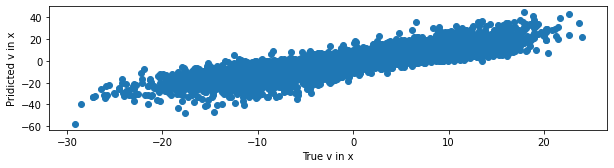

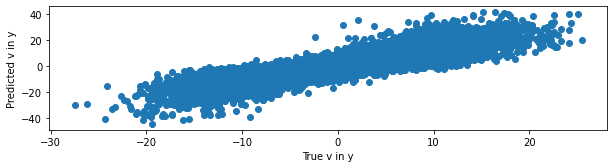

In [10]:
plt.figure(figsize=(10,5))
plt.subplot(211)
plt.scatter(yd_hat[:, 0], ydts[:, 0])
plt.xlabel('True v in x')
plt.ylabel('Pridicted v in x')

plt.figure(figsize=(10,5))
plt.subplot(212)
plt.scatter(yd_hat[:, 1], ydts[:, 1])
plt.xlabel('True v in y')
plt.ylabel('Predicted v in y')

# Selecting the Optimal Delay via Model Order Selection

In [11]:
nred = 6000

# TODO
Xred = X[:nred,:]
yred = y[:nred,:]

In [12]:
import  sklearn.model_selection 
import tqdm.notebook

def create_dly_data(X,y,dly):
    """
    Create delayed data
    """    
    # TODO
    Xtmp = X.copy()
    Xdly = Xtmp
    extra_row = len(X[:,0])
    for i in range(dly):
        Xtmp = np.insert(Xtmp,0,0,axis = 0)
        Xtmp = np.delete(Xtmp,extra_row,0)
        Xdly = np.concatenate((Xdly, Xtmp), axis=1)
    return Xdly, y

nfold = 5  
dmax = 15  

kf = sklearn.model_selection.KFold(n_splits=nfold, random_state=None, shuffle=False)

dtest = np.arange(dmax + 1)
nd = len(dtest)

rsq = np.zeros(nd * nfold).reshape(nd, nfold)

pbar = tqdm.notebook.tqdm(
    total=nfold*nd, initial=0,
    unit='fits', unit_divisor=nd, desc='Model order test')


for it, d in enumerate(dtest):
    Xdly, ydly = create_dly_data(Xred, yred, d)    
    for isplit, Ind in enumerate(kf.split(Xdly)):
        Itr, Its = Ind        
        Xtr = Xdly[Itr,:]
        ytr = ydly[Itr,:]
        Xts = Xdly[Its,:]
        yts = ydly[Its,:]
        reg = LinearRegression().fit(Xtr, ytr)
        yhat = reg.predict(Xts)
        rsq_cur = r2_score(yts, yhat)
        rsq[it, isplit] = rsq_cur
        pbar.update(1)
print(rsq)
pbar.close()

[[0.44087093 0.46124564 0.40227975 0.43713301 0.46391647]
 [0.55334548 0.56854967 0.52226146 0.54688996 0.57682956]
 [0.60152416 0.61420612 0.56948812 0.58948418 0.61533286]
 [0.62613549 0.64416679 0.58634634 0.61175905 0.63564704]
 [0.64009564 0.66570984 0.60030561 0.6287307  0.65182484]
 [0.65357763 0.67705639 0.61271541 0.6421605  0.66530737]
 [0.66142869 0.68290729 0.62520309 0.64981775 0.67398941]
 [0.66274317 0.68227487 0.63155458 0.65604782 0.67819621]
 [0.66404835 0.68102323 0.6327941  0.65925101 0.67779844]
 [0.66424748 0.67894792 0.63106472 0.66064302 0.67450155]
 [0.66422383 0.678103   0.6303853  0.66286255 0.67215031]
 [0.66392919 0.67720395 0.63174423 0.66267354 0.66899617]
 [0.66214512 0.67409233 0.63014116 0.66096827 0.66472253]
 [0.66005744 0.67182797 0.6295127  0.65715427 0.66042383]
 [0.66001128 0.66970892 0.63063897 0.65152425 0.65814756]
 [0.66015019 0.66716196 0.62622379 0.6467129  0.65611603]]



In [13]:
res_vec = np.mean(rsq, axis = 1)
print(res_vec)

[0.44108916 0.55357523 0.59800709 0.62081094 0.63733333 0.65016346
 0.65866925 0.66216333 0.66298303 0.66188094 0.661545   0.66090942
 0.65841388 0.65579524 0.6540062  0.65127297]


In [14]:
best_delay = np.argmax(res_vec)
print('selected model order is ' + str(best_delay))

selected model order is 8


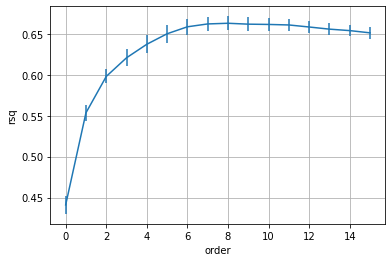

In [15]:
rsq_mean = np.mean(rsq,axis=1)
rsq_std = np.std(rsq,axis=1)/np.sqrt(nfold-1) 

plt.errorbar(dtest, rsq_mean, yerr=rsq_std) 
plt.xlabel('order')
plt.ylabel('rsq')
plt.grid()

In [16]:
rsq_target = res_vec[best_delay] - rsq_std[best_delay] 
I = np.where(rsq_mean > rsq_target)[0]
print('selected model order is ' + str(I[0]))

selected model order is 6
